In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import sys


import logging

# Set up logging


from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("github")

import os

def angular_dist_score(y_true, y_pred):
    az_true = y_true[:,0]
    zen_true = y_true[:,1]
    az_pred = y_pred[:,0]
    zen_pred = y_pred[:,1]
    #if not (tf.all(tf.isfinite(az_true)) and
    #        tf.all(tf.isfinite(zen_true)) and
    #        tf.all(tf.isfinite(az_pred)) and
    #        tf.all(tf.isfinite(zen_pred))):
    #    raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = tf.sin(az_true)
    ca1 = tf.cos(az_true)
    sz1 = tf.sin(zen_true)
    cz1 = tf.cos(zen_true)

    sa2 = tf.sin(az_pred)
    ca2 = tf.cos(az_pred)
    sz2 = tf.sin(zen_pred)
    cz2 = tf.cos(zen_pred)

    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)

    # scalar product of two unit vectors is always between -1 and 1, this is against numerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =tf.clip_by_value(scalar_prod, -1, 1)

    # convert back to an angle (in radian)
    return tf.math.reduce_mean(tf.abs(tf.acos(scalar_prod)))

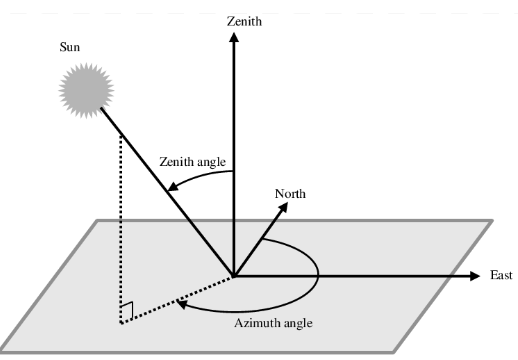

In [2]:
def variables_definition(geom):
    
    geom['sensor_azimuth'] = np.arctan(geom['y']/geom['x'])
    geom['sensor_zenith'] = np.arctan(np.sqrt(geom['x']**2 + geom['y']**2)/geom['z'])
    
    return geom

In [3]:
def dataset_skimmer(df, geom):
    df = df[df['auxiliary']==False] #auxiliary label takes into account the quality of the hits

    df = df.drop(labels='auxiliary', axis=1)

    df['charge'].astype(np.float16()) 
    df_with_geom = df.merge(geom, how = 'left', on = 'sensor_id').reset_index(drop = True)
    
    del df
    
    df_with_geom = df_with_geom.drop(['x', 'y', 'z'], axis = 1)
    
    #drop hits where the same sensor lit, keeping the hit with the highest value of charge 
    
    df_with_geom = df_with_geom.sort_values('charge', ascending = False).drop_duplicates(['event_id', 'sensor_id']).sort_index()
    
    #add a counter of hits per event, and drops hits after the 100th one
    
    df_with_geom['n_counter'] = df_with_geom.groupby('event_id').cumcount()
    df_with_geom  = df_with_geom[df_with_geom.n_counter<100]
    

    df_with_geom.head(15)
    return df_with_geom

In [4]:
def padding_function(df_with_geom):
    
    #find the number of hits per event
    
    maxima = df_with_geom.groupby('event_id')['n_counter'].max().values

    #find the number of rows to be added during the padding

    n_counter_1 = np.where(maxima > 99, maxima, 99)
    diff = np.array([n_counter_1 - maxima])
    df_with_geom.set_index(['event_id', 'n_counter'], inplace= True)
    #print(diff.shape)
    #sys.stdout.flush()

    n_rows = np.sum(diff)

    ev_ids = np.unique(df_with_geom.index.get_level_values(0).values)
    #print("ev_ids", ev_ids.shape)
    #sys.stdout.flush()

    zeros = np.zeros((n_rows, 5), dtype = np.int32)
    
    diff_reshaped = diff.flatten()
    print("len diff",len(diff_reshaped))
    print("shape diff", diff_reshaped.shape)
    sys.stdout.flush()
    ev_ids_reshaped = np.reshape(ev_ids, (len(ev_ids), 1))
 
    print("len ev",len(ev_ids_reshaped))
    print("shape ev", ev_ids_reshaped.shape)
    

    new_index = np.repeat(ev_ids_reshaped, diff_reshaped)

    print("new_index:", new_index)
    sys.stdout.flush()

    #print(df_with_geom.columns)
    #sys.stdout.flush()
    #creates a dataframe filled with zeros to be cancatenated to the data dataframe
    
    pad_df = pd.DataFrame(zeros, index = new_index ,columns=df_with_geom.columns).reset_index(drop = False)
    pad_df['event_id'] = pad_df['index']
    pad_df = pad_df.drop(labels = ['index'], axis =1)
    pad_df['n_counter'] = pad_df.groupby('event_id').cumcount() + df_with_geom.groupby('event_id').cumcount().max() +1
    pad_df = pad_df.set_index(['event_id', 'n_counter'])
    
    #concatenates the two dataframes, and group the hits by event id

    df_final = pd.concat([df_with_geom, pad_df])
    
    df_final = df_final.sort_index()
    df_final = df_final.reset_index(drop= False)

    del df_with_geom, pad_df
    #create a new index that counts all the hits in an event and drops the old counter and the sensor id

    df_final['counter'] = df_final.groupby('event_id').cumcount()
    #print(df_final)
    #sys.stdout.flush()

    df_final = df_final.set_index(['event_id', 'counter'])
    df_final = df_final.drop(labels= ['n_counter', 'sensor_id'], axis = 1)

    return df_final

In [5]:
def dataset_preprocesser(df_final):
    
    #shifts the padded hits to avoid overlap with data hits

    mask_charge = df_final['charge'] == 0
    df_final.loc[mask_charge, 'charge'] = -1

    mask_azimuth = df_final['sensor_azimuth'] == 0
    df_final.loc[mask_azimuth, 'sensor_azimuth'] = -2
    
    mask_zenith = df_final['sensor_zenith'] == 0
    df_final.loc[mask_zenith, 'sensor_zenith'] = -2
    
    
    
    #possibly add more preprocess steps
    
    return df_final

In [6]:
def targets_definer(df_final):
    res = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')

    #because the feature dataset contains information on all the events, results for the single batch need to be extracted 
    #this is a big problem memory-wise, because it takes most of the available memory 
    
    #get the list of event ids
    
    events = df_final.index.get_level_values(0).unique()
    res1  = res[res.event_id.isin(events)]

    res1 = res1.sort_index()
    print("res", res1)
    sys.stdout.flush()
    del res
    return res1

In [7]:
def unstacker(df_final):
    

    #unstack the dataset on the counter level of index, so that all the hits per event are set in a single row
    
    df_final1 = df_final.unstack(level = -1)
    
    #reset the value of the index
    print(df_final1)
    sys.stdout.flush()
    df_final1 = df_final1.reset_index(drop = False)

    return df_final1
    


In [8]:
def model_compiler(X):

    model = keras.Sequential([layers.Dense(units=512, input_shape= [300], activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units= 2, activation = 'linear')])

#    predicted_X = model.predict(X)


    model.compile(optimizer=Adam(learning_rate= 0.001), loss = angular_dist_score)
    
    return model
    

In [9]:
def variables_definer(df_final1, res1):
    
    X = df_final1.loc[:,['charge','sensor_azimuth', 'sensor_zenith']] #variables to be taken from the batch
    Y = res1.loc[:,['azimuth', 'zenith']] #target for the training to be taken from the metadata file
    
    print(X.shape)
    sys.stdout.flush()
    
    return X, Y

In [10]:
def training(X, Y, model):    

    history = model.fit(X, Y,batch_size=128,epochs=30, validation_split = 0.2)
    history_df = pd.DataFrame(history.history)
    # Start the plot at epoch 5. You can change this to get a different view.
    history_df.loc[5:, ['loss', 'val_loss']].plot()


len diff 200000
shape diff (200000,)
len ev 200000
shape ev (200000, 1)
new_index: [     24      24      24 ... 3266196 3266196 3266196]
res         batch_id  event_id  first_pulse_index  last_pulse_index   azimuth  \
0              1        24                  0                60  5.029555   
1              1        41                 61               111  0.417742   
2              1        59                112               147  1.160466   
3              1        67                148               289  5.845952   
4              1        72                290               351  0.653719   
...          ...       ...                ...               ...       ...   
199995         1   3266160           32791961          32792033  1.536491   
199996         1   3266175           32792034          32792157  5.091808   
199997         1   3266192           32792158          32792216  3.605875   
199998         1   3266195           32792217          32792279  3.752771   
199999      

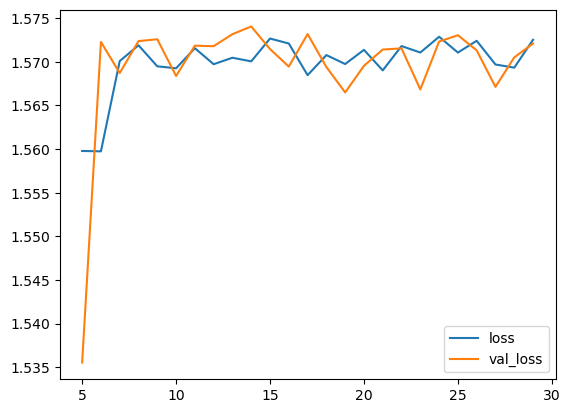

In [11]:
data_path = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/'
data_files = ['batch_1.parquet','batch_2.parquet']
geometry = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
combined_data = pd.DataFrame()
combined_res = pd.DataFrame()

for data_file in data_files:
    
    dataframe = pd.read_parquet(data_path + data_file).reset_index()
    geometry = variables_definition(geometry)
    dataframe_with_geometry = dataset_skimmer(dataframe, geometry)
    dataframe_final = padding_function(dataframe_with_geometry)
    dataframe_final1 = dataset_preprocesser(dataframe_final)
    targets = targets_definer(dataframe_final1)
    dataframe_final2 = unstacker(dataframe_final1)
    
    combined_data = pd.concat([combined_data, dataframe_final2], ignore_index=True)
    
    combined_res = pd.concat([combined_res, targets], ignore_index=True)
    
    
X, Y = variables_definer(combined_data, combined_res)
model_compiled = model_compiler(X) 
    
print("Starting training")
training(X, Y, model_compiled)
    
    
    
    
    
    
    
    
        